## learning-AI : deep learning application (61357002)
### assignment : adult classification using base model from diabetes classification model (DL)

**당뇨 데이터를 1D-CNN한 모델을 기반으로, transfer learning을 통해 adult dataset에 적용**

<br>

- **임규연 (lky473736)**
- 2024.09.30.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/2/adult
- **kaggle** : https://www.kaggle.com/datasets/wenruliu/adult-income-dataset
- **data abstract** : Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

------

## <span id='dl'><mark>DL</mark></span>

- **Reference**
    - https://github.com/MyungKyuYi/AI-class/blob/main/Pre-trained_model.ipynb
    - https://github.com/MyungKyuYi/AI-class/blob/main/fixed_code.ipynb
    - https://github.com/lky473736/learning-AI/blob/main/class/assignment/topic4/CNN(transfer-learning)_classification_diabetes(assignment).ipynb

<br>

이번 문서에서는, `./CNN(transfer-learning)_classification_diabetes(assignment)`에서 만든 base model을 근간으로 해서, 새로운 dataset인 **adult income dataset**에 맞게끔 fine-tuning한다. 따라서 아래와 같은 목차로 진행한다.

- **1. adult income dataset : 간단한 탐색적 데이터 분석 및 데이터 전처리 수행, 순환 데이터로 구성**
- **2. transfer learning - pre-trained model, fine-tuning**

In [128]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

In [129]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


-----------



### 1. 간단한 탐색적 데이터 분석 및 데이터 전처리 수행, 순환 데이터로 구성
- 데이터 시각화 및 필요한 정보를 얻어낸다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- 순환 데이터로 구성하기 위하여 split_sequence를 빈도 기준으로 한다.

In [130]:
# 각 데이터프레임의 column 이름

columns = ['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country', 'target']

print (columns)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'target']


각 column에 따른 정보는 아래와 같다. 

- **age (나이)**: 개인의 나이를 나타내는 연속형 변수.

- **workclass (직업 계층)**: 개인의 고용 유형. 
  - **Private**: 민간 부문 직원.
  - **Self-emp-not-inc**: 법인 설립이 안 된 자영업자.
  - **Self-emp-inc**: 법인 설립된 자영업자.
  - **Federal-gov**: 연방 정부 직원.
  - **Local-gov**: 지방 정부 직원.
  - **State-gov**: 주 정부 직원.
  - **Without-pay**: 무급 근로자.
  - **Never-worked**: 근로 경험 없음.

- **fnlwgt**: 조사된 인구 데이터의 가중치.

- **education (학력 수준)**: 개인이 받은 교육 수준.
  - **Bachelors**: 학사 학위.
  - **Some-college**: 일부 대학교 과정.
  - **HS-grad**: 고등학교 졸업.
  - 그 외에 **Doctorate**, **Masters**, **11th** 등.

- **education-num (교육 연수)**: 교육의 연수를 나타내는 연속형 변수.

- **marital-status (결혼 상태)**: 결혼 상태.
  - **Married-civ-spouse**: 법적 결혼.
  - **Divorced**: 이혼.
  - **Never-married**: 미혼.
  - **Separated**: 별거 중.
  - **Widowed**: 배우자 사망.
  - **Married-spouse-absent**: 배우자와 떨어져 있음.
  - **Married-AF-spouse**: 군인 배우자와 결혼.

- **occupation (직업)**: 개인의 직업.
  - **Tech-support**: 기술 지원.
  - **Sales**: 판매업.
  - **Exec-managerial**: 경영 및 관리.

- **relationship (가족 관계)**: 가정 내 관계.
  - **Husband**: 남편.
  - **Wife**: 아내.
  - **Own-child**: 자녀.
  - **Not-in-family**: 가족이 아님.
  - **Other-relative**: 다른 친척.
  - **Unmarried**: 미혼.

- **race (인종)**: 인종.
  - **White**: 백인.
  - **Black**: 흑인.
  - **Asian-Pac-Islander**: 아시아인 및 태평양 섬 주민.
  - **Amer-Indian-Eskimo**: 아메리카 원주민 및 에스키모.
  - **Other**: 그 외 인종.

- **sex (성별)**: 성별.
  - **Male**: 남성.
  - **Female**: 여성.

- **capital-gain (자본 이득)**: 자산 처분 시 발생한 자본 이득.

- **capital-loss (자본 손실)**: 자산 처분 시 발생한 자본 손실.

- **hours-per-week (주당 근로 시간)**: 주당 근로 시간을 나타내는 연속형 변수.

- **native-country (출생 국가)**: 개인의 출생 국가.
  - **United-States**: 미국.
  - **Mexico**: 멕시코.
  - **India**: 인도 등.

- **target (목표 변수)**: 개인의 소득 수준. **<=50K 또는 >50K**로 소득이 50,000달러 이하인지 초과인지를 나타냄

In [131]:
# train data 파일, test data 파일 읽기

df_train = pd.read_csv("../../data/adult/adult_train.csv", names=columns)
df_test = pd.read_csv("../../data/adult/adult_test.csv", names=columns)

print (df_test.iloc[0]) # 1행은 전부 NaN으로 되어 있는 것을 확인. 
df_test.drop(0, inplace=True) 

print (df_train.head(2))
print (df_test.head(2))

age               |1x3 Cross validator
workclass                          NaN
fnlwgt                             NaN
education                          NaN
education-num                      NaN
marital-status                     NaN
occupation                         NaN
relationship                       NaN
race                               NaN
sex                                NaN
capital-gain                       NaN
capital-loss                       NaN
hours-per-week                     NaN
native-country                     NaN
target                             NaN
Name: 0, dtype: object
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   

        marital-status        occupation    relationship    race    sex  \
0        Never-married      Adm-clerical   Not-in-family   White   Male   
1   Married-civ-spouse   Exec-managerial         

In [132]:
# df의 기본적인 통계량 수치 파악, 각 열마다의 데이터 타입 

for feature in df_train.columns :
    print (f'df_train | {feature}의 데이터 타입 : ', df_train[feature].dtype)

for feature in df_test.columns :
    print (f'df_test | {feature}의 데이터 타입 : ', df_test[feature].dtype)   

df_train.describe()
df_test.describe()

df_train | age의 데이터 타입 :  int64
df_train | workclass의 데이터 타입 :  object
df_train | fnlwgt의 데이터 타입 :  int64
df_train | education의 데이터 타입 :  object
df_train | education-num의 데이터 타입 :  int64
df_train | marital-status의 데이터 타입 :  object
df_train | occupation의 데이터 타입 :  object
df_train | relationship의 데이터 타입 :  object
df_train | race의 데이터 타입 :  object
df_train | sex의 데이터 타입 :  object
df_train | capital-gain의 데이터 타입 :  int64
df_train | capital-loss의 데이터 타입 :  int64
df_train | hours-per-week의 데이터 타입 :  int64
df_train | native-country의 데이터 타입 :  object
df_train | target의 데이터 타입 :  object
df_test | age의 데이터 타입 :  object
df_test | workclass의 데이터 타입 :  object
df_test | fnlwgt의 데이터 타입 :  float64
df_test | education의 데이터 타입 :  object
df_test | education-num의 데이터 타입 :  float64
df_test | marital-status의 데이터 타입 :  object
df_test | occupation의 데이터 타입 :  object
df_test | relationship의 데이터 타입 :  object
df_test | race의 데이터 타입 :  object
df_test | sex의 데이터 타입 :  object
df_test | capital-gain의 데이터 타입 :  float6

,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


위를 보면 알 수 있듯이, 대부분의 column은 **문자열로 이루어진 범주형**임을 알 수 있다. 따라서 각 범주형을 label encoding하여 추후 활동을 진행하겠다. **그 전에, 결측치부터 확인해보겠다. adult_train.csv를 열어보면, 가끔가다 특정 샘플의 특정 col에서 "?"이라고 하는 값이 존재하는 것을 알 수 있다. ?가 포함된 records를 제거해야 하겠다.**

In [133]:
# ?이나, null이 포함된 record를 찾아서 제거

print(df_train.isnull().sum())
print()
print(df_test.isnull().sum())

print("Before preprocessing | ", df_train.shape, df_test.shape)

df_train = df_train.dropna() # 결측치 제거함
df_test = df_test.dropna()

# df_train_list = []
# df_test_list = []

# for ind in range(len(df_train)) : # ?가 들어간 record는 제외하여 list에 넣기
#     if not any(df_train[col].dtype == 'object' and '?' in str(df_train.at[ind, col]) for col in df_train.columns) :
#         df_train_list.append(df_train.loc[ind])

# for ind in range(len(df_test)) :
#     if not any(df_test[col].dtype == 'object' and '?' in str(df_test.at[ind, col]) for col in df_test.columns) :
#         df_test_list.append(df_test.loc[ind])

# df_train = pd.DataFrame(df_train_list) # 그 리스트로 다시 dataframe을 구성함
# df_test = pd.DataFrame(df_test_list)

df_train_list = []
df_test_list = []

for ind in range(len(df_train)) : # '?' 문자가 있는 행 제거 (iloc 사용)
    if not any(df_train[col].dtype == 'object' and '?' in str(df_train.iloc[ind][col]) for col in df_train.columns):
        df_train_list.append(df_train.iloc[ind])

for ind in range(len(df_test)) :
    if not any(df_test[col].dtype == 'object' and '?' in str(df_test.iloc[ind][col]) for col in df_test.columns):
        df_test_list.append(df_test.iloc[ind])

df_train = pd.DataFrame(df_train_list)
df_test = pd.DataFrame(df_test_list)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print("After preprocessing | ", df_train.shape, df_test.shape)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64
Before preprocessing |  (32561, 15) (16281, 15)
After preprocessing |  (30162, 15) (15060, 15)


In [134]:
# test 데이터 파일의 마지막 target 열의 온점을 모두 제거 (train과 통일성 위해)

for ind in range(df_test.shape[0]) :
    # 'target' 열의 마지막 문자가 온점인 경우 제거
    df_test.loc[ind, 'target'] = df_test.loc[ind, 'target'].rstrip('.')

In [135]:
# 문자열로 이루어진 범주형인 column을 모두 label encoding

from sklearn.preprocessing import LabelEncoder

for col in df_train.columns : 
    if df_train[col].dtype == "object" :
        print (f'{col} is object')
        l_e = LabelEncoder()
        
        df_train[col] = l_e.fit_transform(df_train[col])
        df_test[col] = l_e.transform(df_test[col])
        
df_train

workclass is object
education is object
marital-status is object
occupation is object
relationship is object
race is object
sex is object
native-country is object
target is object


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,27,2,257302,7,12,2,12,5,4,0,0,0,38,38,0
30158,40,2,154374,11,9,2,6,0,4,1,0,0,40,38,1
30159,58,2,151910,11,9,6,0,4,4,0,0,0,40,38,0
30160,22,2,201490,11,9,4,0,3,4,1,0,0,20,38,0


<Axes: xlabel='target', ylabel='count'>

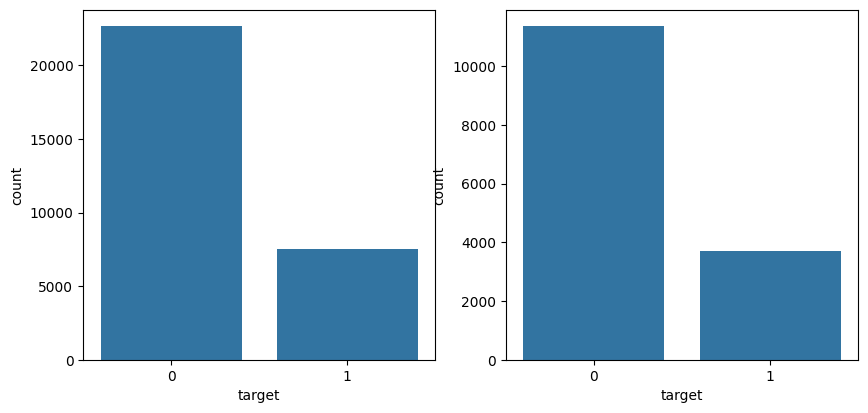

In [136]:
# target countplot 

# plt.subplot(221)
# sns.countplot(df_train['target'])

# plt.subplot(222)
# sns.countplot(df_test['target'])

plt.figure(figsize=(10, 10))

plt.subplot(221)
sns.countplot(data=df_train, x='target')

plt.subplot(222)
sns.countplot(data=df_test, x='target')

현재 0이 income이 50 이하, 1이 income이 50 초과인 records를 나타내는 class이다. 위 상황이 당연한게, 고소득자가 저소득자보다 낮을 수밖에 없다. **하지만, 0과 1 클래스를 제대로 분배하지 않고 train data, test data, val data를 만들면 당연하게도 class bias가 일어날 것이다.**

따라서 나는 아래와 같이 2개의 생각을 하였고, 그를 실행에 옮겼다. 결과를 먼저 말하자면, 두번째 방법을 채택하여 구성하였다.

- (1) 이번 데이터셋에서 split_sequence를 이용해 순환 데이터를 만들 때에는 새로운 방법을 도입할 것이다. **어차피 고소득자가 저소득자보다 인원이 적은 것은 당연한 것이다. 따라서 이번에는 특정 window에서 고소득자가 등장하였을 경우 target을 1로 도입할 것이다.** 그니깐, 특정 표본에서 고소득자가 있는가, 없는가를 알아맞추는 모델을 만든다는 의미가 되겠다. **하지만...**
    - <img src="./heatmap_way1.png" width="500px">
    - **fine-tuning을 하여도, 위와 같은 처참한 confusion matrix를 맞이하게 되었다.**
        - 잘 생각해보면 위 결과가 당연하다. 이유는 당연히 클래스 편향이랑 옳지 않은 로직이다.
        - 각 window에 고소득자가 1번은 반드시 등장하였기 때문에 위와 같은 결과가 나왔을 것

- (2) **일단 train set과 test set을 나중에 합쳐버리고, randomize unit을 이용하여 각 class에 해당되는 sample들을 oversampling하자. 데이터가 많아야 학습이 원활할 것이다.**
    - 따라서 이 방법으로 진행하는데, 빈도를 기준으로 순환 데이터를 구성하기 바로 직전에 oversampling을 진행한다. 그 전까지는 train set 기준으로 EDA를 진행할 것이다.

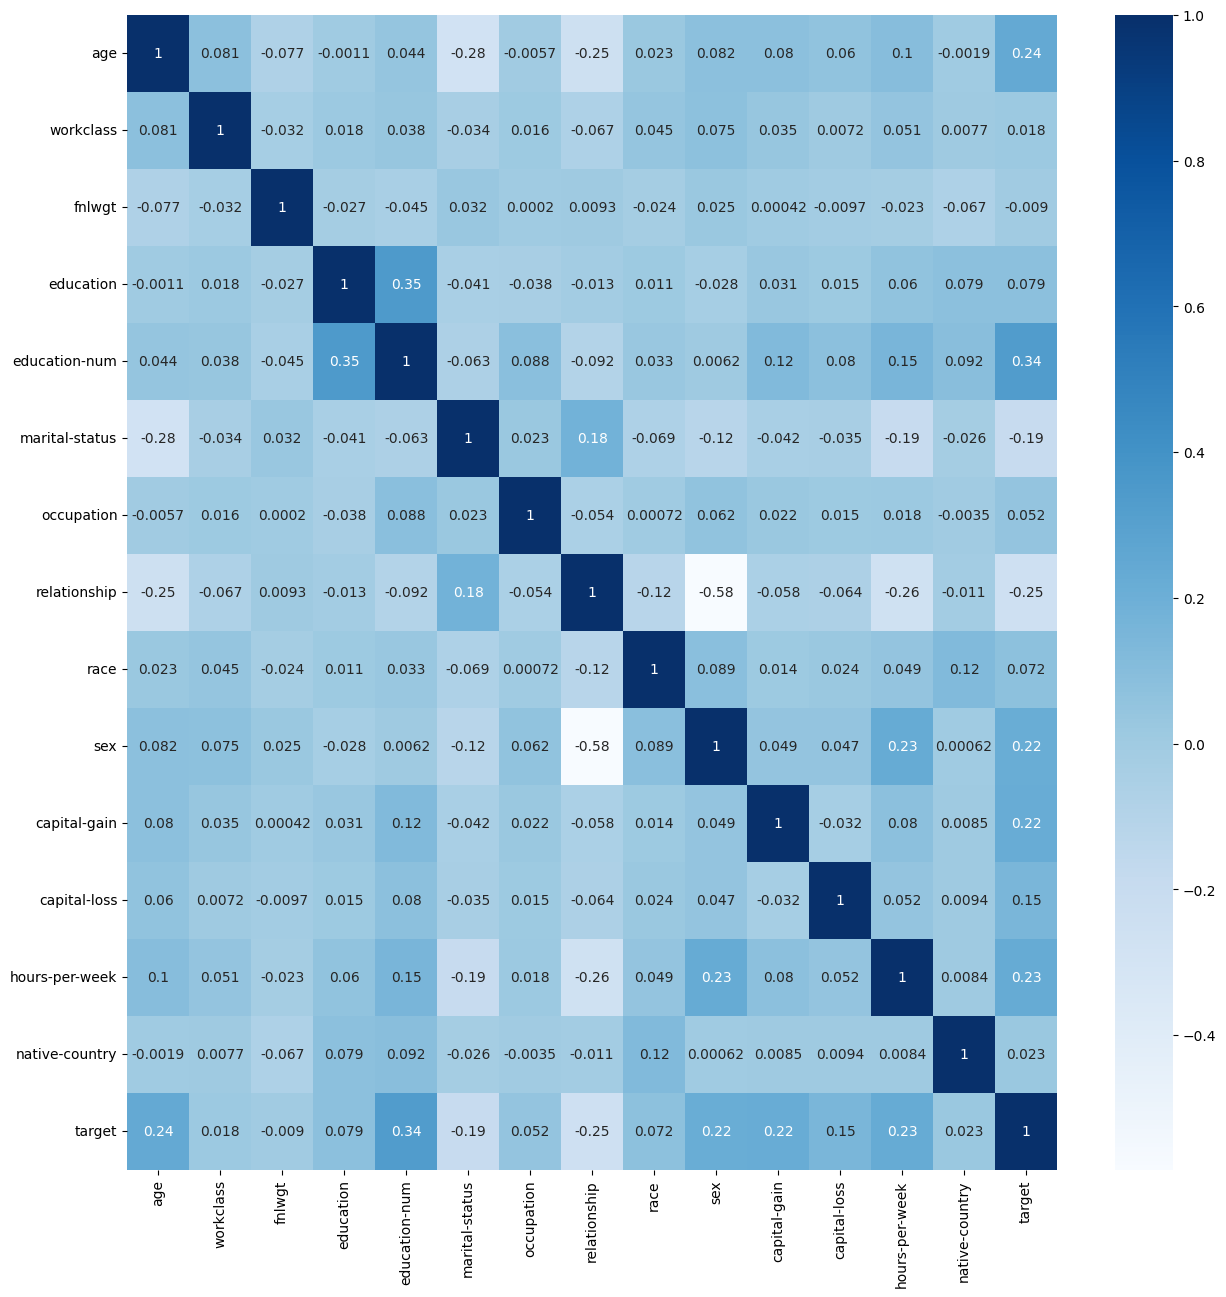

In [137]:
# heatmap 그리기 

'''
    train의 heatmap만 그린다. 그런 후에 feature selection을 진행하겠다.
'''

plt.figure(figsize=(15, 15))

df_train_corr = df_train.corr()
sns.heatmap(df_train_corr, annot=True, cbar=True,
           cmap='Blues', annot_kws={"size": 10})
plt.show()

이 문서에서 다룰 **base_model은 diabetes dataset에 맞추어져 있다. 따라서 input shape 또한 diabetes dataset에 맞추어서 구성해야 할 것이다. diabetes는 feature가 8개, 현재 adults income dataset은 feature가 14개이니, 그럴려면 불필요한 feature을 제외하고 필요한 feature만 feature selection 해야한다.** 해당 상관행렬(correlation matrix)을 바탕으로 feature selection을 한다면, target과 높은 상관관계를 가지는 변수들을 선택하는 것이 좋다고 생각한다. target과의 상관계수를 기준으로 상위 8개 컬럼을 선택하자. 이는 아래와 같다.

1. **education-num** (0.34)
2. **age** (0.24)
3. **sex** (0.22)
4. **hours-per-week** (0.23)
5. **capital-gain** (0.22)
6. **relationship** (-0.25)
7. **marital-status** (-0.19)
8. **capital-loss** (0.15)

이 변수들을 선택하는 이유는 **target과의 상관관계가 높아, 모델의 예측 성능에 긍정적인 영향을 줄 가능성**이 있기 때문이다. 의문이 들 수 있는데, 위 feature 중 상관관계가 음수인 것도 있는데 위 8개를 선택해야 하는 이유는, 상관계수의 **절댓값**이 큰 것이 상관관계가 높다고 가정하기 때문이다. 각 feature에 따라서 weight와 bias가 epoch마다 결정되기 때문에, 여기서 중요한 건, 모든 상관관계가 양수인 것이 아닌, 절댓값이 높은 상관관계이다.

In [138]:
# feature selection하여 다시 df를 구성

selected_features = [
    "education-num",
    "age",
    "sex",
    "hours-per-week",
    "capital-gain",
    "relationship",
    "marital-status",
    "capital-loss",
    "target" # target 마지막에 추가
]

df_train = df_train[selected_features]
df_test = df_test[selected_features]

df_train

,education-num,age,sex,hours-per-week,capital-gain,relationship,marital-status,capital-loss,target
0,13,39,1,40,2174,1,4,0,0
1,13,50,1,13,0,0,2,0,0
2,9,38,1,40,0,1,0,0,0
3,7,53,1,40,0,0,2,0,0
4,13,28,0,40,0,5,2,0,0
...,...,...,...,...,...,...,...,...,...
30157,12,27,0,38,0,5,2,0,0
30158,9,40,1,40,0,0,2,0,1
30159,9,58,0,40,0,4,6,0,0
30160,9,22,1,20,0,3,4,0,0


In [139]:
# train set, test set 합치기 -> oversampling

from sklearn.model_selection import train_test_split

df = pd.concat([df_train, df_test], axis=0)
adult_input = df.drop('target', axis=1)
adult_target = df['target']

In [140]:
# 각 열의 데이터 타입 확인

print(df.dtypes)

# age의 dtype을 int로 변경
df['age'] = df['age'].astype('int64')
print(df.dtypes)

education-num     float64
age                object
sex                 int64
hours-per-week    float64
capital-gain      float64
relationship        int64
marital-status      int64
capital-loss      float64
target              int64
dtype: object
education-num     float64
age                 int64
sex                 int64
hours-per-week    float64
capital-gain      float64
relationship        int64
marital-status      int64
capital-loss      float64
target              int64
dtype: object


In [141]:

'''
    oversampling과 undersampling을 함수로 구현한다. 
'''
    
def sampling(df, target_col, max_size) :
    # 결과를 저장할 리스트 
    dfs = []
    
    for label in df[target_col].unique() :
        class_df = df[df[target_col] == label]
        
        if len(class_df) < max_size :
            # 샘플 수가 max_size보다 적으면 데이터를 복제하여 max_size로 만듦
            sampled_df = class_df.sample(max_size, replace=True, random_state=42)
        else :
            # 샘플 수가 max_size보다 많으면 앞부분부터 max_size만큼 선택함
            sampled_df = class_df.head(max_size)
        
        # 리스트에 추가
        dfs.append(sampled_df)
    
    df_resampled = pd.concat(dfs).reset_index(drop=True)
    
    return df_resampled

df_resampled = sampling(df, 'target', max_size=10000)
print (df_resampled['target'].value_counts())

target
0    10000
1    10000
Name: count, dtype: int64


In [142]:
# input, target split

input_adult = df_resampled.drop('target', axis=1)
target_adult = df_resampled['target']

input_adult.shape, target_adult.shape

((20000, 8), (20000,))

In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_adult,
                                                    target_adult,
                                                    stratify=target_adult,
                                                    test_size = 0.2, shuffle=True) 

# X_train, X_val, y_train, y_val = train_test_split(X_train,
#                                                     y_train,
#                                                     stratify=y_train,
#                                                     test_size = 0.2, shuffle=True) 

X_train.shape, X_test.shape

((16000, 8), (4000, 8))

In [144]:
'''
    순환 데이터를 구성하기 위하여 split_sequences를 사용하였다.
    이때, 각 window마다 class의 빈도 수를 측정하여 가장 많은 빈도수를 가진 class가 target이 되는 방식을 취하였다.
'''

from collections import Counter
import numpy as np

def split_sequences_freq(sequences, n_steps):
    X, y = list(), list()
    
    # Check if sequences is a DataFrame, convert if necessary
    if not isinstance(sequences, pd.DataFrame):
        sequences = pd.DataFrame(sequences)

    for i in range(len(sequences)):
        end_ix = i + n_steps

        if end_ix > len(sequences):
            break

        seq_x = sequences.iloc[i:end_ix, :-1].values
        seq_y = sequences.iloc[i:end_ix, -1].values   
        
        # Find the most frequent class in seq_y
        most_frequent_class = Counter(seq_y).most_common(1)[0][0]
        
        X.append(seq_x)
        y.append(int(most_frequent_class))

    return np.array(X), np.array(y)

In [145]:
# 순환 데이터 구성

train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]
# val_set = np.c_[X_val, y_val]

X_train_seq, y_train_seq = split_sequences_freq(train_set, 5) # 5개씩 묶기
print (X_train_seq)
print (y_train_seq)

print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences_freq(test_set, 5) # 5개씩 묶기
print (X_test_seq)
print (y_test_seq)

print ("test : ", X_test_seq.shape, y_test_seq.shape)

# X_val_seq, y_val_seq = split_sequences_freq(val_set, 5) # 5개씩 묶기
# print (X_val_seq)
# print (y_val_seq)

# print ("val : ", X_val_seq.shape, y_val_seq.shape)

[[[9.000e+00 4.100e+01 1.000e+00 ... 0.000e+00 2.000e+00 0.000e+00]
  [6.000e+00 4.300e+01 1.000e+00 ... 0.000e+00 2.000e+00 0.000e+00]
  [1.000e+01 2.100e+01 0.000e+00 ... 3.000e+00 4.000e+00 0.000e+00]
  [1.300e+01 2.600e+01 1.000e+00 ... 1.000e+00 4.000e+00 0.000e+00]
  [1.300e+01 3.700e+01 1.000e+00 ... 0.000e+00 2.000e+00 0.000e+00]]

 [[6.000e+00 4.300e+01 1.000e+00 ... 0.000e+00 2.000e+00 0.000e+00]
  [1.000e+01 2.100e+01 0.000e+00 ... 3.000e+00 4.000e+00 0.000e+00]
  [1.300e+01 2.600e+01 1.000e+00 ... 1.000e+00 4.000e+00 0.000e+00]
  [1.300e+01 3.700e+01 1.000e+00 ... 0.000e+00 2.000e+00 0.000e+00]
  [1.000e+01 4.700e+01 0.000e+00 ... 2.000e+00 0.000e+00 0.000e+00]]

 [[1.000e+01 2.100e+01 0.000e+00 ... 3.000e+00 4.000e+00 0.000e+00]
  [1.300e+01 2.600e+01 1.000e+00 ... 1.000e+00 4.000e+00 0.000e+00]
  [1.300e+01 3.700e+01 1.000e+00 ... 0.000e+00 2.000e+00 0.000e+00]
  [1.000e+01 4.700e+01 0.000e+00 ... 2.000e+00 0.000e+00 0.000e+00]
  [1.000e+01 3.500e+01 1.000e+00 ... 0.000e+

In [146]:
# 실제로 어떻게 구성되었는지 X_train_seq와 y_train_seq의 앞쪽 5개의 component만 출력

print (np.isnan(y_train_seq).sum())

for idx in range (5) :
    print (f"X_train_seq[{idx}] : ", X_train_seq[idx][:5])
    print (f"y_train_seq[{idx}] : ", y_train_seq[idx])
    
    if idx == 0 : 
        prev = X_train_seq[idx]
        print()
        continue

    if (prev[1:] == X_train_seq[idx][:-1]).all() : 
        '''
            step 1씩 이동했으니깐, 이전 X_train_seq 원소의 2번째 record ~ 마지막번째 record와
            현재 X_train_seq 원소의 첫번째 record ~ 마지막-1번째 record는 같을 수밖에 없습니다.
        '''
         
        print ("window가 step 1씩 이동하면서 순환 데이터를 만듦")
    
    prev = X_train_seq[idx]
    print()

0
X_train_seq[0] :  [[9.000e+00 4.100e+01 1.000e+00 4.000e+01 5.178e+03 0.000e+00 2.000e+00
  0.000e+00]
 [6.000e+00 4.300e+01 1.000e+00 4.200e+01 0.000e+00 0.000e+00 2.000e+00
  0.000e+00]
 [1.000e+01 2.100e+01 0.000e+00 2.000e+01 0.000e+00 3.000e+00 4.000e+00
  0.000e+00]
 [1.300e+01 2.600e+01 1.000e+00 4.800e+01 0.000e+00 1.000e+00 4.000e+00
  0.000e+00]
 [1.300e+01 3.700e+01 1.000e+00 4.500e+01 0.000e+00 0.000e+00 2.000e+00
  0.000e+00]]
y_train_seq[0] :  0

X_train_seq[1] :  [[ 6. 43.  1. 42.  0.  0.  2.  0.]
 [10. 21.  0. 20.  0.  3.  4.  0.]
 [13. 26.  1. 48.  0.  1.  4.  0.]
 [13. 37.  1. 45.  0.  0.  2.  0.]
 [10. 47.  0. 40.  0.  2.  0.  0.]]
y_train_seq[1] :  0
window가 step 1씩 이동하면서 순환 데이터를 만듦

X_train_seq[2] :  [[10. 21.  0. 20.  0.  3.  4.  0.]
 [13. 26.  1. 48.  0.  1.  4.  0.]
 [13. 37.  1. 45.  0.  0.  2.  0.]
 [10. 47.  0. 40.  0.  2.  0.  0.]
 [10. 35.  1. 40.  0.  0.  2.  0.]]
y_train_seq[2] :  0
window가 step 1씩 이동하면서 순환 데이터를 만듦

X_train_seq[3] :  [[13. 26.  1. 48.  

In [147]:
# one-hot encoding 

from tensorflow.keras.utils import to_categorical

y_train_seq_encoded = to_categorical(y_train_seq)
y_test_seq_encoded = to_categorical(y_test_seq)
# y_val_seq_encoded = to_categorical(y_val_seq)

print(y_train_seq[:5])  
print(y_train_seq_encoded[:5]) 

print(y_test_seq[:5])  
print(y_test_seq_encoded[:5])

# print(y_val_seq[:5])  
# print(y_val_seq_encoded[:5])

[0 0 0 1 1]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[1 1 1 0 0]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]



-----

### 2. transfer learning - pre-trained model, fine-tuning
아래와 같은 순서로 진행된다.

- **(1) pre-trained model 불러오기** : diabetes를 사전 학습된 모델을 로드한다.
  - `load_model()` 함수를 사용하여 기존 모델을 불러온다.

- **(2) Layer 동결 (trainable=False 설정) 및 Fine-tuning 설정** : convolutional layers는 freezing하고, Dense layers만 재학습할 수 있도록 설정한다.
  - Convolutional layers은 이전 특징을 잡아내므로 고정한다.
  - Dense layers를 추가하여 학습을 진행한다.

- **(3) Dense layers 추가** 

- **(4) trainable=True로 설정 후 모델 재학습 (fine-tuning)** 

In [148]:
# base 모델 로드 './model/base_CNN-DNN_diabetes.h5'

from tensorflow.keras.models import load_model

model_file = './model/base_CNN-DNN_diabetes.h5'

base_model = load_model(model_file)
base_model

<Functional name=functional_30, built=True>

In [149]:
# base 모델에 train data, test data를 evaluate시켜본다.

X_train_seq = np.array(X_train_seq, dtype=np.float32)
y_train_seq_encoded = np.array(y_train_seq_encoded, dtype=np.float32)

X_test_seq = np.array(X_test_seq, dtype=np.float32)
y_test_seq_encoded = np.array(y_test_seq_encoded, dtype=np.float32)

base_model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

print ("train : ", base_model.evaluate(X_train_seq, y_train_seq_encoded))
print ("test : ", base_model.evaluate(X_test_seq, y_test_seq_encoded))

eval_1 = base_model.evaluate(X_test_seq, y_test_seq_encoded)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - accuracy: 0.4087 - loss: 300.8661
train :  [300.4655456542969, 0.4149162173271179]
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4024 - loss: 300.6558
test :  [287.3994445800781, 0.42167165875434875]
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.4024 - loss: 300.6558


위는 diabetes dataset을 학습시켰던 `'./model/base_CNN-DNN_diabetes.h5'`에 아무런 layer의 추가 없이, adult dataset을 대입하였을 때 어떤 loss와 acc가 나오는지를 확인한 것이다. 일단은 현재 adult income dataset에서 train set, test set 또한 diabetes dataset의 input shape와 동일하기 때문에 evaluate를 사용할 때 오류가 없었던 것이다.

**하지만, 그리 좋지 않은 loss, acc가 나온 것을 확인할 수 있다.** 이를 해결하기 위하여 trainable=False를 통하여 pre-trained model 자체를 가동시킨 후에 이전 trainable 파라미터를 True로 하여 fine-tuning을 적용한다.

In [150]:
# 이전 모델의 feature extraction 부분을 trainable=False로 둔다. (학습이 새롭게 되어 가중치 학습 X)

for i, layer in enumerate(base_model.layers) : 
    print (f'{i+1}번째 layer (base_model) : {layer}')
    
print ()

model_layers = []

for i in range (0, len(base_model.layers)-1) : # -1하여 마지막 출력층은 추가하지 않도록 함
    base_model.layers[i].trainable = False # 학습하지 않도록 False로 구성
    model_layers.append (base_model.layers[i])
    
print ()

for i, layer in enumerate(base_model.layers) : 
    if layer.trainable == False : 
        print (f'{i+1}번째 layer인 {layer}의 trainable 여부가 False가 됨')

1번째 layer (base_model) : <InputLayer name=input_layer_2, built=True>
2번째 layer (base_model) : <Conv1D name=conv1d_6, built=True>
3번째 layer (base_model) : <BatchNormalization name=batch_normalization_6, built=True>
4번째 layer (base_model) : <Dropout name=dropout_16, built=True>
5번째 layer (base_model) : <Conv1D name=conv1d_7, built=True>
6번째 layer (base_model) : <BatchNormalization name=batch_normalization_7, built=True>
7번째 layer (base_model) : <Dropout name=dropout_17, built=True>
8번째 layer (base_model) : <Conv1D name=conv1d_8, built=True>
9번째 layer (base_model) : <BatchNormalization name=batch_normalization_8, built=True>
10번째 layer (base_model) : <Dropout name=dropout_18, built=True>
11번째 layer (base_model) : <Flatten name=flatten_2, built=True>
12번째 layer (base_model) : <Dense name=dense_20, built=True>
13번째 layer (base_model) : <Dense name=dense_21, built=True>
14번째 layer (base_model) : <Dense name=dense_22, built=True>


1번째 layer인 <InputLayer name=input_layer_2, built=True>의 train

In [151]:
# 끝에 클래스 수만큼 노드를 배치하여 분류할 수 있도록 한다 (기존 모델의 마지막 열은 가져오면 안된다 (출력층은 X))

model_transfer = Sequential(model_layers)
model_transfer.add(Dropout(0.2, name='dropout_01'))
model_transfer.add(Dense(16, activation='relu', name='dense_01'))
model_transfer.add(Dropout(0.2, name='dropout_02'))
model_transfer.add(Dense(2, activation='sigmoid', name='output'))

# compile
model_transfer.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

# visualization
model_transfer.summary()
display_layers = [(layer, layer.name, layer.trainable) for layer in model_transfer.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 4, 64)          │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 4, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 4, 16)          │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_01 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_01 (Dense)                │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_02 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,086 (58.93 KB)

 Trainable params: 530 (2.07 KB)

 Non-trainable params: 14,556 (56.86 KB)

,Layer Type,Layer Name,Layer Trainable
0,"<Conv1D name=conv1d_6, built=True>",conv1d_6,False
1,<BatchNormalization name=batch_normalization_6...,batch_normalization_6,False
2,"<Dropout name=dropout_16, built=True>",dropout_16,False
3,"<Conv1D name=conv1d_7, built=True>",conv1d_7,False
4,<BatchNormalization name=batch_normalization_7...,batch_normalization_7,False
5,"<Dropout name=dropout_17, built=True>",dropout_17,False
6,"<Conv1D name=conv1d_8, built=True>",conv1d_8,False
7,<BatchNormalization name=batch_normalization_8...,batch_normalization_8,False
8,"<Dropout name=dropout_18, built=True>",dropout_18,False
9,"<Flatten name=flatten_2, built=True>",flatten_2,False


In [152]:
# fit

from memory_profiler import profile

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model(model, X_train_seq, y_train_seq) :
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    
    history = model.fit(X_train_seq, y_train_seq, epochs=100, 
                        validation_split=0.2,
                        batch_size=256,
                        callbacks=[early_stopping_cb], 
                        verbose=True, shuffle=True)
    
    return history

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (n_steps, 특징 수)
history_transfer = train_model(model_transfer, X_train_seq, y_train_seq_encoded)

ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_33827/1056478489.py
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5298 - loss: 267.0230 - val_accuracy: 0.5231 - val_loss: 67.4352
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4943 - loss: 178.6007 - val_accuracy: 0.5222 - val_loss: 28.5849
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4985 - loss: 127.2714 - val_accuracy: 0.5216 - val_loss: 14.3142
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5076 - loss: 86.7263 - val_accuracy: 0.4919 - val_loss: 12.0384
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5114 - loss: 67.3703 - val_accuracy: 0.4466 - val_loss: 9.0455
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4973 - loss: 45.6012 - val_accuracy: 0.4347 - val_loss: 4.7327
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5094 - loss: 34.3270 - val_accuracy: 0.4803 - val_los

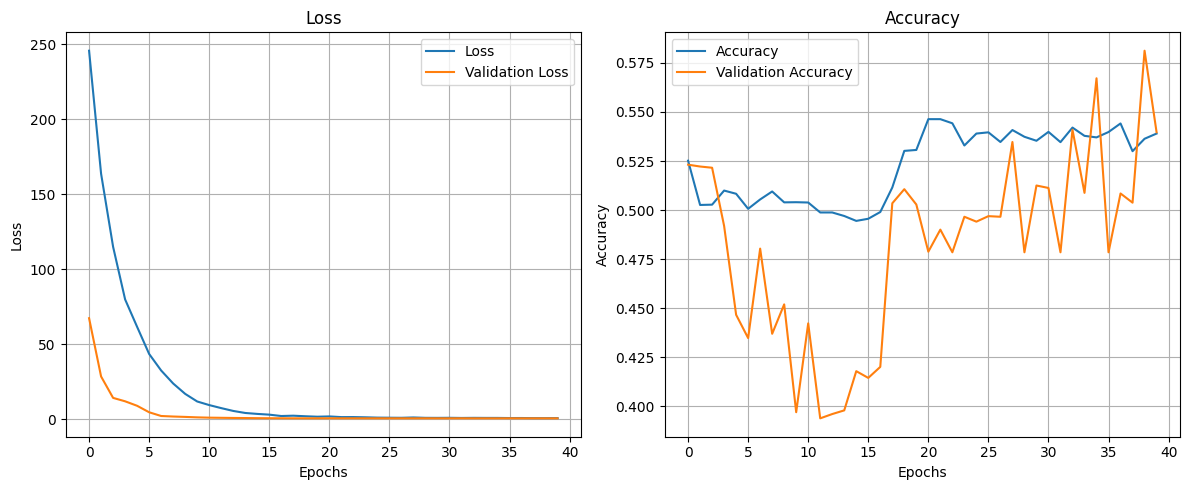

In [153]:
# loss와 validation loss, acc와 validation acc를 시각화하기 위한 메소드

def draw_history (history) :
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history.history['loss'], label='Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(history.history['accuracy'], label='Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

draw_history(history_transfer)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix


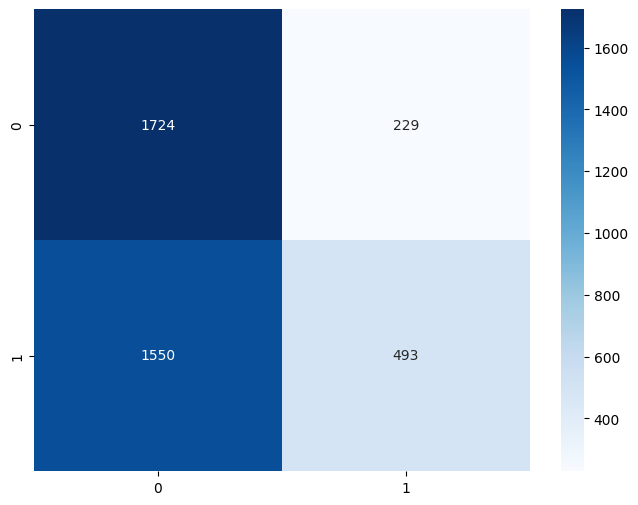

              precision    recall  f1-score   support

           0       0.53      0.88      0.66      1953
           1       0.68      0.24      0.36      2043

    accuracy                           0.55      3996
   macro avg       0.60      0.56      0.51      3996
weighted avg       0.61      0.55      0.50      3996



In [154]:
# confusion matrix, classification report, accuracy

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_test_arg = np.argmax(y_test_seq_encoded, axis=1)
Y_pred = np.argmax(model_transfer.predict(X_test_seq),axis=1)
print ('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# confusion matrix 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# classification report
report = classification_report(y_test_arg, Y_pred)
print (report)

**당연히 fine-tuning하기 전이니 model이 위와 같은 끔찍한 결과를 낳을 수밖에 없을 것. 이제 아래에 fine-tuning을 진행한다.**

In [155]:
# evaluate

print ("train score : ", model_transfer.evaluate(X_train_seq, y_train_seq_encoded))
print ("test score : ", model_transfer.evaluate(X_test_seq, y_test_seq_encoded))

eval_2 = model_transfer.evaluate(X_test_seq, y_test_seq_encoded)

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.5753 - loss: 0.6880
train score :  [0.6877872943878174, 0.5692673325538635]
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5777 - loss: 0.6817
test score :  [0.6853972673416138, 0.554804801940918]
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5777 - loss: 0.6817


In [156]:
# fine tuning 진행을 위해 trainable=True 후 다시 modeling

model_layers = []

for i in range (0, len(base_model.layers)-1) : # -1하여 마지막 출력층은 추가하지 않도록 함
    if base_model.layers[i].trainable == False : 
        base_model.layers[i].trainable = True 
        
        model_layers.append (base_model.layers[i])
    
print ()

# Dropout과 Dense 레이어 추가
model_transfer.add(Dropout(0.5, name='dropout_5'))
model_transfer.add(Dense(128, activation='relu', name='dense_5'))
model_transfer.add(Dropout(0.2, name='dropout_6'))
model_transfer.add(Dense(64, activation='relu', name='dense_6'))
model_transfer.add(Dropout(0.3, name='dropout_7'))
model_transfer.add(Dense(32, activation='relu', name='dense_7'))
model_transfer.add(Dropout(0.2, name='dropout_8'))
model_transfer.add(Dense(16, activation='relu', name='dense_8'))
model_transfer.add(Dense(2, activation='sigmoid', name='output_layer_new'))


# 모델 컴파일
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# visualization
model_transfer.summary()
display_layers = [(layer, layer.name, layer.trainable) for layer in model_transfer.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 4, 64)          │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 4, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 4, 16)          │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_01 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_01 (Dense)                │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_02 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,368 (103.00 KB)

 Trainable params: 26,144 (102.12 KB)

 Non-trainable params: 224 (896.00 B)

,Layer Type,Layer Name,Layer Trainable
0,"<Conv1D name=conv1d_6, built=True>",conv1d_6,True
1,<BatchNormalization name=batch_normalization_6...,batch_normalization_6,True
2,"<Dropout name=dropout_16, built=True>",dropout_16,True
3,"<Conv1D name=conv1d_7, built=True>",conv1d_7,True
4,<BatchNormalization name=batch_normalization_7...,batch_normalization_7,True
5,"<Dropout name=dropout_17, built=True>",dropout_17,True
6,"<Conv1D name=conv1d_8, built=True>",conv1d_8,True
7,<BatchNormalization name=batch_normalization_8...,batch_normalization_8,True
8,"<Dropout name=dropout_18, built=True>",dropout_18,True
9,"<Flatten name=flatten_2, built=True>",flatten_2,True


In [157]:
# re-fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

history_transfer = model_transfer.fit(X_train_seq, y_train_seq_encoded, epochs=100, 
                        validation_split=0.2,
                        batch_size=128,
                        callbacks=[early_stopping_cb], 
                        verbose=True, shuffle=True)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4963 - loss: 0.6936 - val_accuracy: 0.4784 - val_loss: 0.6942
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5102 - loss: 0.6932 - val_accuracy: 0.4784 - val_loss: 0.6932
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5105 - loss: 0.6915 - val_accuracy: 0.6216 - val_loss: 0.6843
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5725 - loss: 0.6813 - val_accuracy: 0.6278 - val_loss: 0.6785
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5865 - loss: 0.6757 - val_accuracy: 0.6303 - val_loss: 0.6724
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5878 - loss: 0.6726 - val_accuracy: 0.6447 - val_loss: 0.6662
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5868 - loss: 0.6703 - val_accuracy: 0.6272 - val_loss: 0.6718
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5899 - loss: 0.6708 - val_acc

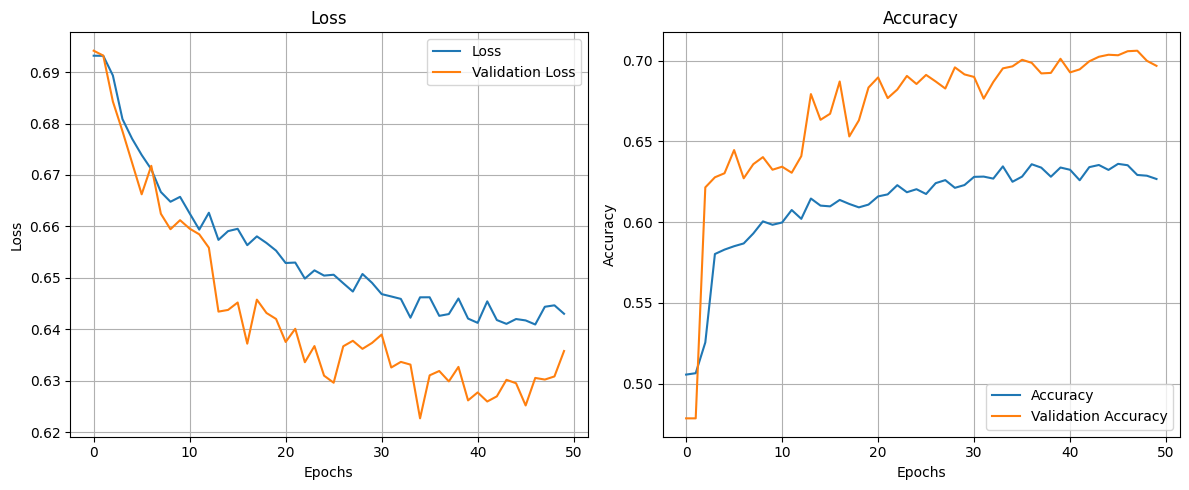

In [158]:
# loss와 validation loss, acc와 validation acc를 시각화하기 위한 메소드

def draw_history (history) :
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history.history['loss'], label='Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(history.history['accuracy'], label='Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

draw_history(history_transfer)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix


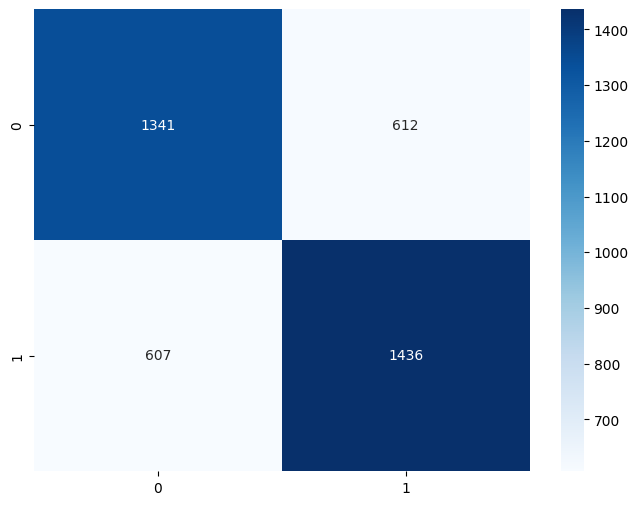

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1953
           1       0.70      0.70      0.70      2043

    accuracy                           0.69      3996
   macro avg       0.69      0.69      0.69      3996
weighted avg       0.69      0.69      0.69      3996



In [159]:
# confusion matrix, classification report, accuracy

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_test_arg = np.argmax(y_test_seq_encoded, axis=1)
Y_pred = np.argmax(model_transfer.predict(X_test_seq),axis=1)
print ('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# confusion matrix 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# classification report
report = classification_report(y_test_arg, Y_pred)
print (report)

In [160]:
# evaluate

print ("train score : ", model_transfer.evaluate(X_train_seq, y_train_seq_encoded))
print ("test score : ", model_transfer.evaluate(X_test_seq, y_test_seq_encoded))

eval_3 = model_transfer.evaluate(X_test_seq, y_test_seq_encoded)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6962 - loss: 0.6238
train score :  [0.6234647631645203, 0.6959239840507507]
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6891 - loss: 0.6253
test score :  [0.6229097843170166, 0.6949449181556702]
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6891 - loss: 0.6253


-----

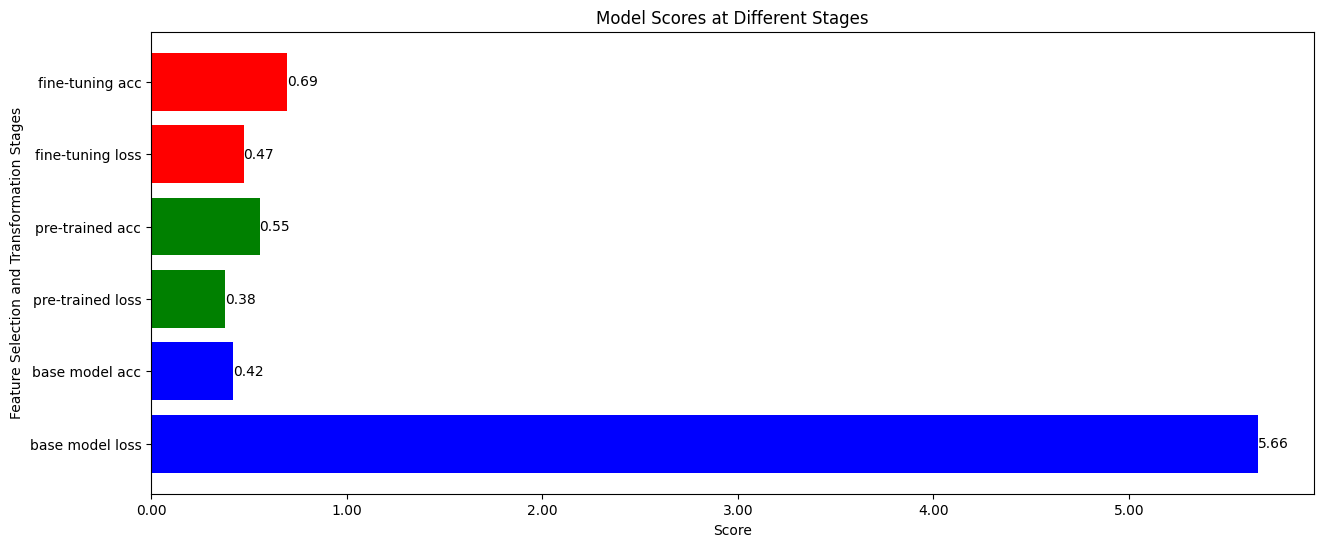

In [161]:
'''
    종합적으로 보기 위해 loss와 accuracy를 막대 그래프로 나타냄
'''

import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

labels = [
    'base model loss',
    'base model acc',
    'pre-trained loss',
    'pre-trained acc',
    'fine-tuning loss',
    'fine-tuning acc',
]

score1 = eval_1
score2 = eval_2
score3 = eval_3

scores = [math.log(score1[0]), score1[1], -math.log(score2[0]), score2[1], -math.log(score3[0]), score3[1]]

plt.figure(figsize=(15, 6))
bars = plt.barh(labels, scores, color=['blue', 'blue', 'green', 'green', 'red', 'red'])

for bar in bars:
    yval = bar.get_width()
    plt.text(yval, bar.get_y() + bar.get_height()/2, f'{yval:.2f}', ha='left', va='center')

plt.xlabel('Score')
plt.ylabel('Feature Selection and Transformation Stages')
plt.title('Model Scores at Different Stages')

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # 소수점 2자리로 설정

plt.show()
